# Notebook de modelos de regressão

## Importação das bibliotecas

In [ ]:
import cmdstanpy
#!pip install cmdstanpy

In [ ]:
#!pip install prophet

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet

In [3]:
def wmape(y_true, y_pred):
    """
    Calcula o Weighted Mean Absolute Percentage Error (WMAPE).

    Args:
        y_true (array-like): Valores reais.
        y_pred (array-like): Valores previstos.

    Returns:
        float: O valor do WMAPE. Retorna np.nan se a soma dos valores reais absolutos for zero
               para evitar divisão por zero.
    """
    # Garante que y_true e y_pred são arrays numpy para operações elemento a elemento
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calcula o erro absoluto
    absolute_error = np.abs(y_true - y_pred)

    # Soma dos valores reais absolutos
    sum_abs_y_true = np.sum(np.abs(y_true))

    # Evita divisão por zero
    if sum_abs_y_true != 0:
        wmape_value = np.sum(absolute_error) / sum_abs_y_true
    else:
        wmape_value = np.nan # Retorna NaN se a soma dos valores reais absolutos for zero

    return wmape_value

In [4]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

In [5]:
input_path = '../data/processed/dados_historicos_ibovespa_2015-2025_processed.csv'

df = pd.read_csv(input_path, index_col='ds', parse_dates=['ds'])
df.tail()

,close,open,high,low,volume,daily_return,return_lag_1,return_lag_2,return_lag_3,return_lag_4,...,close_lag7,sma_21,ema_50,rsi_14,atr_14,obv,day_of_week,day_of_month,month,year
ds,,,,,,,,,,,,,,,,,,,,,
2025-06-12,137800,137127,137931,136175,7.120000e+09,0.0049,0.0051,0.0054,-0.0030,-0.0010,...,137546.0,137814.619048,134894.977670,56.429439,1746.368879,1.365133e+11,3,12,6,2025
2025-06-13,137213,137800,137800,136586,8.630000e+09,-0.0043,0.0049,0.0051,0.0054,-0.0030,...,137002.0,137713.619048,134985.880507,53.149650,1708.342531,1.278833e+11,4,13,6,2025
2025-06-16,139256,137212,139988,137212,7.620000e+09,0.0149,-0.0043,0.0049,0.0051,0.0054,...,136236.0,137716.904762,135153.336173,61.530240,1784.603778,1.355033e+11,0,16,6,2025
2025-06-17,138840,139256,139497,138293,8.380000e+09,-0.0030,0.0149,-0.0043,0.0049,0.0051,...,136102.0,137679.000000,135297.911225,59.207770,1743.132080,1.271233e+11,1,17,6,2025
2025-06-18,138717,138844,139161,138443,8.320000e+09,-0.0009,-0.0030,0.0149,-0.0043,0.0049,...,135699.0,137612.666667,135431.993138,58.504620,1669.908360,1.188033e+11,2,18,6,2025


## Pré-processamento dos dados

In [6]:
target = 'close'

# Seleção de Features (X)
# Adicionar lag do 'close' como feature
df['close_lag1'] = df['close'].shift(1)
df['close_lag3'] = df['close'].shift(3)
df['close_lag5'] = df['close'].shift(5)
df['close_lag7'] = df['close'].shift(7) # Exemplo: preço de fechamento de 7 dias atrás

### Decomposição da série temporal

In [7]:
# Decompor série temporal
annual_period = 252 # ano do pregão
df_decomposed = seasonal_decompose(df['close'], model='multiplicative', period=annual_period)

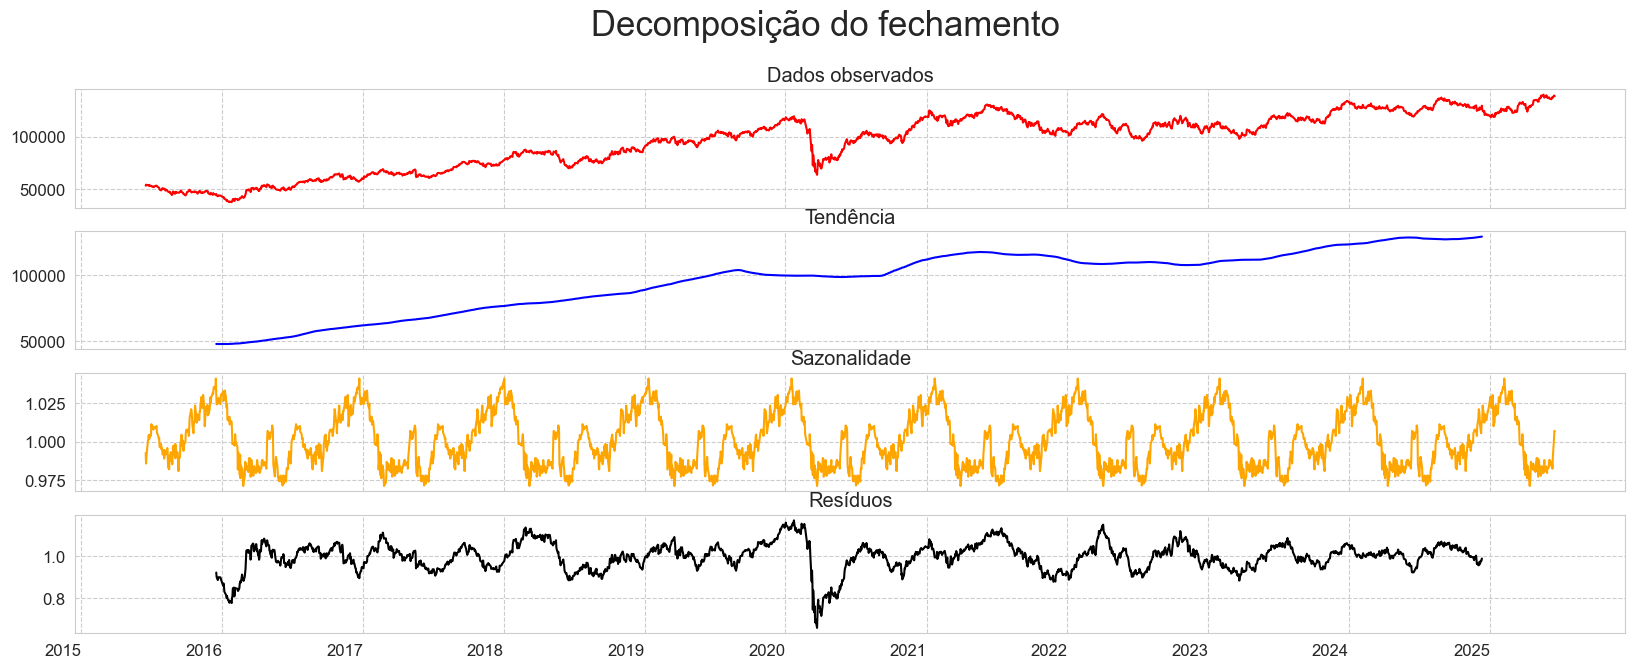

In [8]:
fig, axes = plt.subplots(4, 1, sharex=True,figsize = (20, 8))

df_decomposed.observed.plot(ax = axes[0], title = 'Dados observados', color='red')
df_decomposed.trend.plot(ax = axes[1], title = 'Tendência', color='blue')
df_decomposed.seasonal.plot(ax = axes[2], title = 'Sazonalidade', color='orange')
df_decomposed.resid.plot(ax = axes[3], title = 'Resíduos', color='black')

# Título e rótulos dos eixos
fig.suptitle('Decomposição do fechamento')
axes[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.xlabel('')
plt.xticks(rotation='horizontal')

plt.show()

### Estacionariedade

O teste ADF (Augmented Dickey-Fuller) verifica se a série é estacionaria, ou seja, como as propriedades mudam ao longo do tempo.

* Hipótese Nula (H₀): A série NÃO é estacionária (ela possui uma raiz unitária).
* Hipótese Alternativa (H₁): A série É estacionária (ela não possui uma raiz unitária).

In [22]:
def is_stationary(series):

  adf = adfuller(series)
  print(f'Teste Estatístico ADF: {adf[0]}')
  print(f'Valor-p do Teste ADF: {adf[1]}')

  # Nível de significância de 95%
  if adf[1] > 0.05:
    print('Não rejeitar a hipótese nula: a série NÃO é estacionária')
  else:
    print('Rejeitar a hipótese nula: a série é estacionária')


# Fechamento
print('Fechamento')
is_stationary(df['close'].values)

print('--------')

# Retorno diário
print('Retorno diário')
is_stationary(df['daily_return'].values)


Fechamento
Teste Estatístico ADF: -1.317399277350216
Valor-p do Teste ADF: 0.6211750088335108
Não rejeitar a hipótese nula: a série NÃO é estacionária
--------
Retorno diário
Teste Estatístico ADF: -18.100030090418166
Valor-p do Teste ADF: 2.555229133585602e-30
Rejeitar a hipótese nula: a série é estacionária


Para modelos clássicos de Machine Learning, vamos usar o retorno diário como alvo, já que é estacionário. Assim, as relações que eles aprendem entre as features e o alvo têm mais chance de se manterem válidas no futuro. Já para modelos específicos de supervisão de séries tempoirais, que foram explicitamente projetados para lidar com dados não-estacionários, vamos usar o fechamento como alvo.

In [10]:
print('Fechamento diferenciado 1x')
is_stationary(df['close'].diff().dropna().values)

Fechamento diferenciado 1x
Teste Estatístico ADF: -15.958745056991473
Valor-p do Teste ADF: 7.218372774289596e-29
Rejeitar a hipótese nula: a série é estacionária


### Autocorrelação

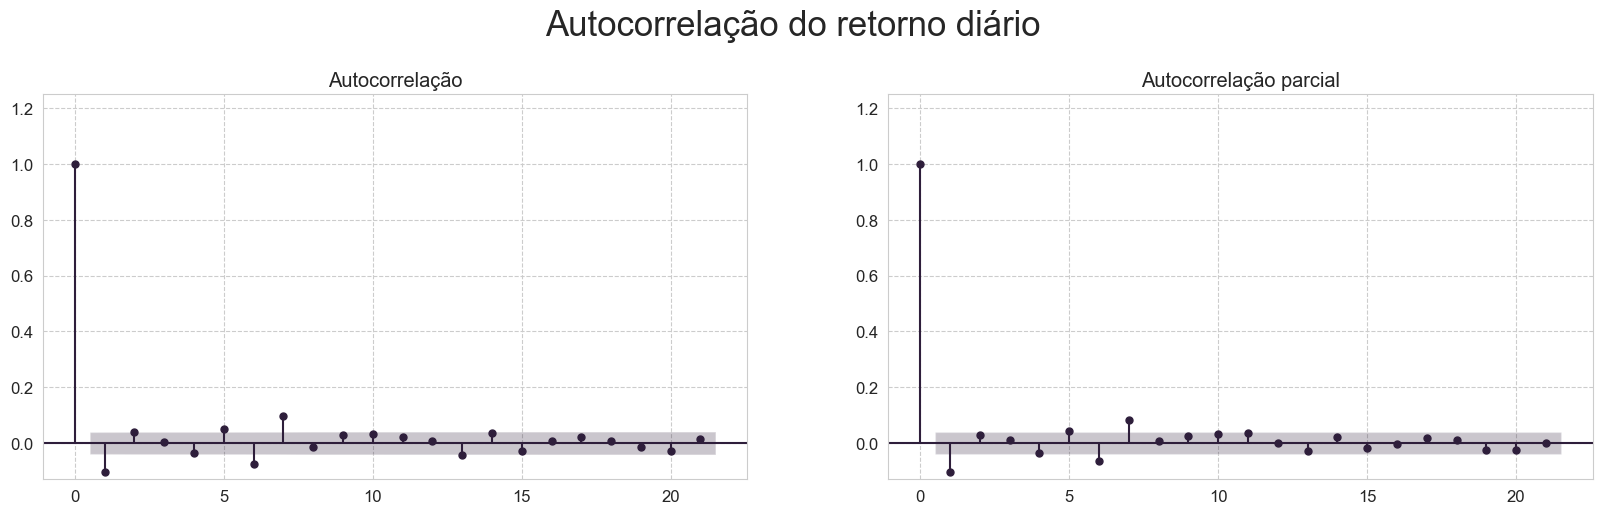

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))

plot_acf(df['daily_return'], lags = 21, title = 'Autocorrelação', auto_ylims = True, ax = axes[0])
plot_pacf(df['daily_return'], lags = 21, title = 'Autocorrelação parcial', auto_ylims = True, ax = axes[1])
plt.suptitle('Autocorrelação do retorno diário', y=1.05)
plt.show()

O retorno de ontem (return_lag_1) parace ter significância no retorno diário.

## Construção de modelos de regressão clássicos

In [12]:
# Lista de features candidatas
features = [
    'close_lag1', 'close_lag3', 'close_lag5','close_lag7', # Adicionando lags do target
    'daily_return', # Se o target for 'close', podemos usar o daily_return D-1 como feature, ou o daily_return_lag_1
    'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5',
    'momentum_5', 'momentum_21', 'momentum_63',
    'sma_21', 'ema_50', 'rsi_14', 'atr_14', 'obv',
    'day_of_week', 'month', # day_of_month pode ter muita variação
]

# Excluir linhas com NaN (resultantes dos lags)
df_clean = df.dropna(subset=features + [target])

# Definir X e y
X = df_clean[features]
y = df_clean[target]

In [ ]:
# definindo variáveis preditoras e variável alvo
#X = df[features]
#y = df['close']
#y = df['daily_return']

In [13]:
# precisamos defasar as features para não usar dados do futuro e evitar overfitting
X_shifted = X.shift(1).dropna()
y = y.loc[X_shifted.index]

In [ ]:
# divisão entre treino e teste (30 dias de pregão, conforme requisito) de forma cronológica (sem aleatoriedade)
#X_train, X_test, y_train, y_test = train_test_split(X_shifted, y, test_size=30, shuffle=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

print(f"Tamanho do treino: {len(X_train)} amostras")
print(f"Tamanho do teste: {len(X_test)} amostras")

Tamanho do treino: 2445 amostras
Tamanho do teste: 30 amostras


In [14]:
# Dividir dados em treino e teste (respeitando a ordem temporal)
# Exemplo: 80% treino, 20% teste
train_size = int(len(df_clean) * 0.8)
X_train, X_test = X_shifted.iloc[:train_size], X_shifted.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [15]:
# definindo modelos de regressão
seed = 42
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1),
    'XGBoost Regressor': xgb.XGBRegressor(
                                        objective='reg:squarederror', # Objetivo para regressão
                                        learning_rate=0.05,          # Taxa de aprendizado
                                        n_estimators=300,            # Número de árvores
                                        max_depth=5,                 # Profundidade máxima das árvores
                                        subsample=0.8,               # Fração de amostras por árvore
                                        colsample_bytree=0.8,        # Fração de features por árvore
                                        random_state=42,             # Para reprodutibilidade
                                        n_jobs=-1 )
}

In [16]:
# treinando os modelos
for name, model in models.items():
    print(f"Treinando {name}...")
    model.fit(X_train, y_train)

print("Todos os modelos foram treinados!")

Treinando Linear Regression...
Treinando Random Forest Regressor...
Treinando XGBoost Regressor...
Todos os modelos foram treinados!


In [17]:
# comparando o desempenho dos modelos
regression_results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    # Calcula as métricas de regressão
    mae = (mean_absolute_error(y_test, y_pred))
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Calcula a acurácia direcional
    # Compara o sinal (+) ou (-) da previsão com o sinal do valor real
    directional_accuracy = np.mean(np.sign(y_pred) == np.sign(y_test)) * 100
    
    # Armazena todos os resultados no dicionário
    regression_results[name] = {
        'MAE': f'{mae:.2f}',
        'MSE': f'{mse:.2f}',
        'R2 Score': f'{r2:.4f}',
        'Acurácia Direcional (%)': directional_accuracy
    }

performance = pd.DataFrame.from_dict(regression_results, orient='index').sort_values(by='Acurácia Direcional (%)', ascending=False)
performance

,MAE,MSE,R2 Score,Acurácia Direcional (%)
Linear Regression,4687.02,10936.83,-2.0593,100.0
Random Forest Regressor,2609.31,3819.08,0.6270,100.0
XGBoost Regressor,2749.78,3944.76,0.6020,100.0


In [ ]:
performance.idxmax().loc['Acurácia Direcional (%)']

'Linear Regression'

In [18]:
best_model_name = performance.idxmax().loc['Acurácia Direcional (%)']
best_model = models[best_model_name]

# 2. Criar um DataFrame com os resultados para facilitar a plotagem
df_results = pd.DataFrame({
    'Retorno Real': y_test,
    'Retorno Previsto': best_model.predict(X_test)
})

# 3. Calcular os erros (resíduos)
df_results['Residuos'] = df_results['Retorno Real'] - df_results['Retorno Previsto']
df_results.head()

,Retorno Real,Retorno Previsto,Residuos
ds,,,
2023-06-27,117523,118556.484923,-1033.484923
2023-06-28,116681,118017.034657,-1336.034657
2023-06-29,118383,116942.174335,1440.825665
2023-06-30,118087,117852.400974,234.599026
2023-07-03,119673,118020.301595,1652.698405


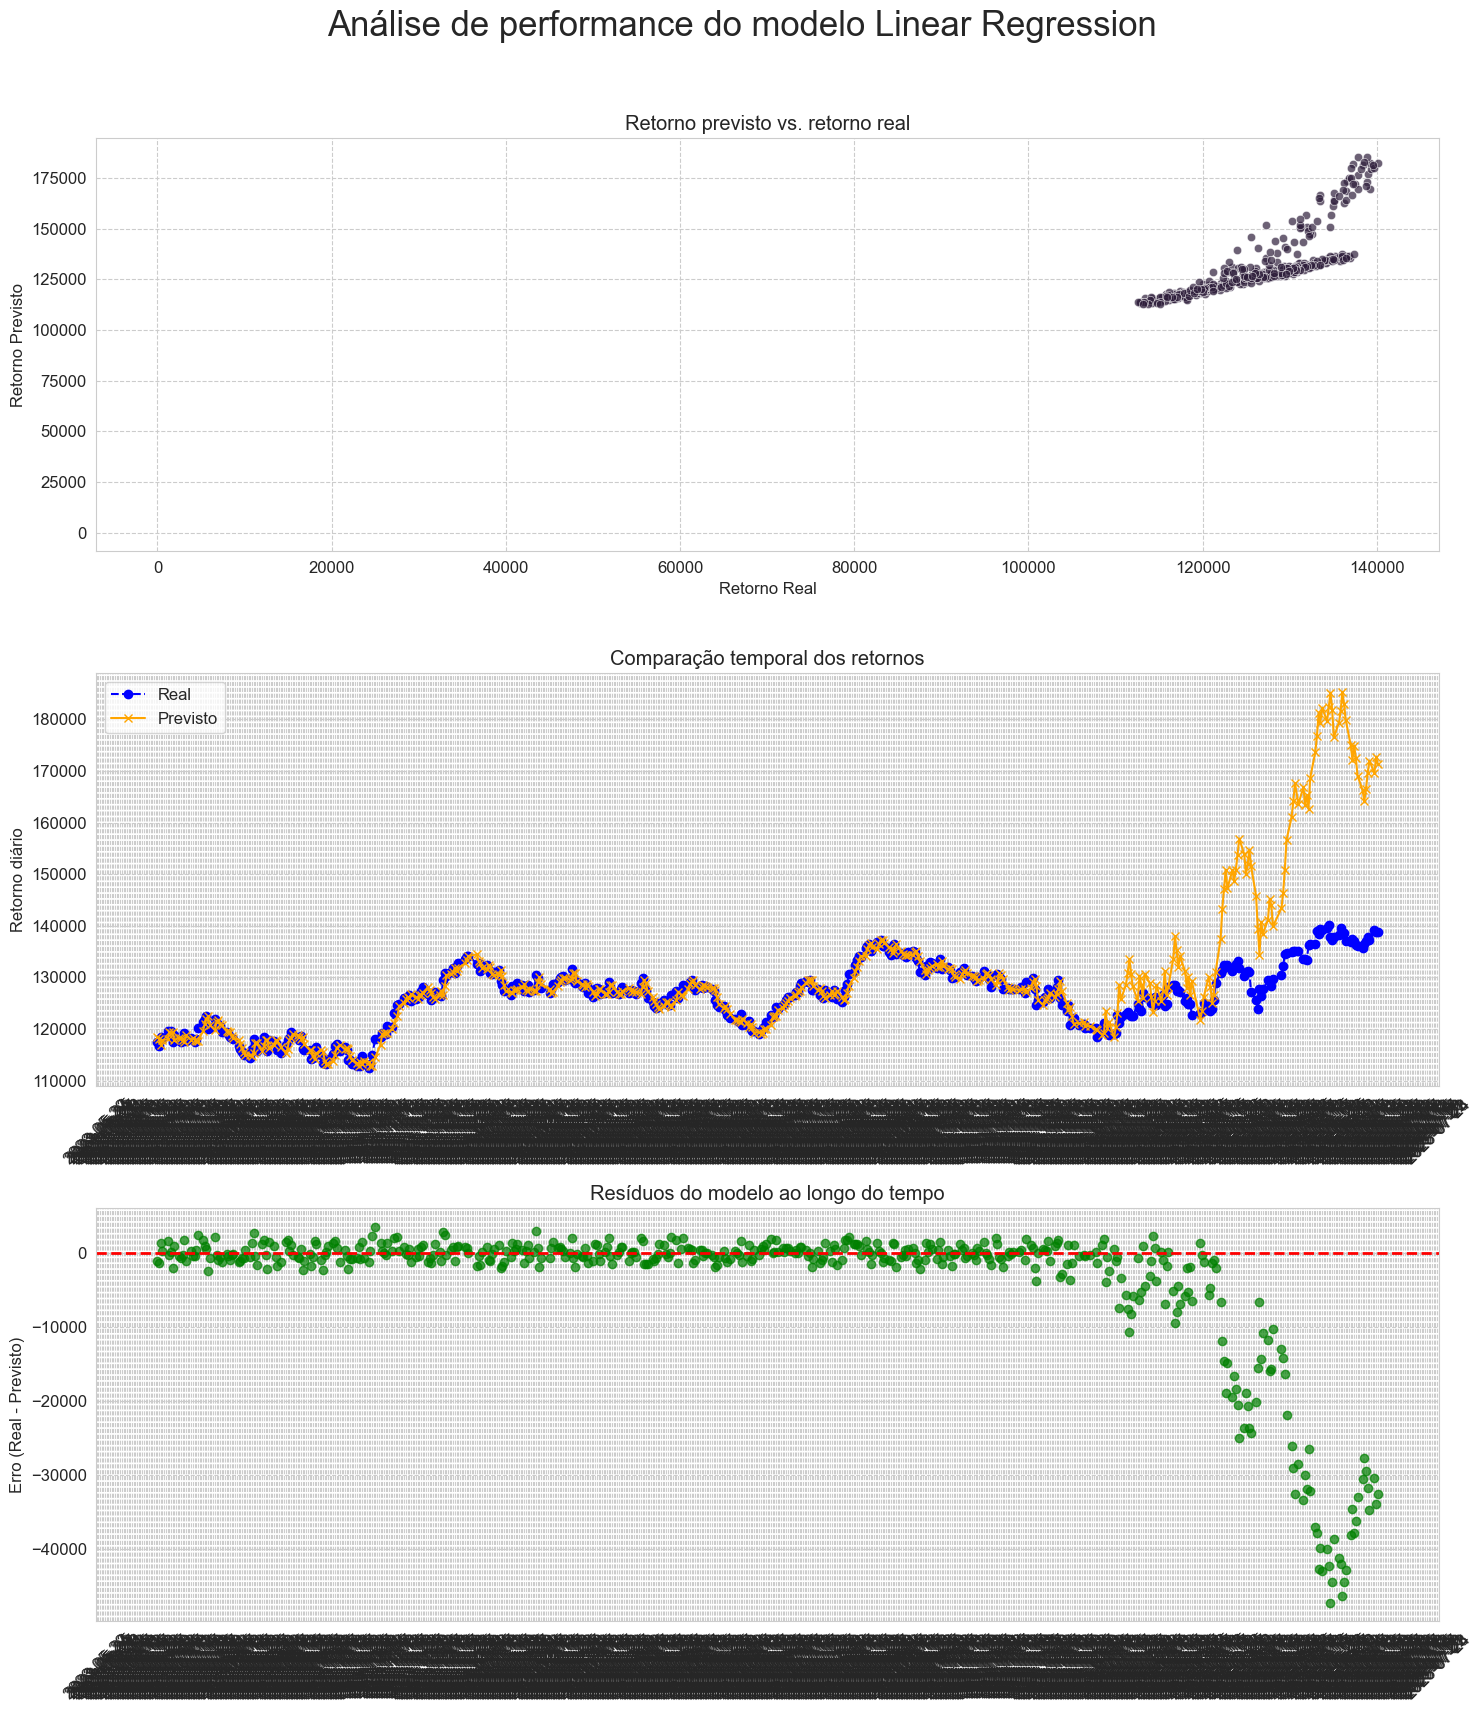

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18))
fig.suptitle(f'Análise de performance do modelo {best_model_name}')

# scatter Plot de previsto vs. real
sns.scatterplot(ax=axes[0], x='Retorno Real', y='Retorno Previsto', data=df_results, alpha=0.7)
axes[0].plot([-0.05, 0.05], [-0.05, 0.05], color='red', linestyle='--', lw=2)
axes[0].set_title('Retorno previsto vs. retorno real')
axes[0].set_xlabel('Retorno Real')
axes[0].set_ylabel('Retorno Previsto')

# série temporal (linhas do previsto e real ao longo do tempo)
axes[1].plot(df_results.index, df_results['Retorno Real'], label='Real', color='blue', marker='o', linestyle='--')
axes[1].plot(df_results.index, df_results['Retorno Previsto'], label='Previsto', color='orange', marker='x', linestyle='-')
axes[1].set_title('Comparação temporal dos retornos')
axes[1].set_xlabel('')
axes[1].set_ylabel('Retorno diário')

# Configura o eixo x com ticks diários
axes[1].xaxis.set_major_locator(mdates.DayLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# análise de resíduos
axes[2].scatter(df_results.index, df_results['Residuos'], alpha=0.7, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', lw=2)
axes[2].set_title('Resíduos do modelo ao longo do tempo')
axes[2].set_xlabel('')
axes[2].set_ylabel('Erro (Real - Previsto)')

axes[2].xaxis.set_major_locator(mdates.DayLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [21]:
# hiperparâmetros que iremos testar
param_grid_xgb = {
    'n_estimators': [100, 200, 300],        # Número de árvores (rodadas de boosting)
    'max_depth': [3, 5, 7],                 # Profundidade máxima de cada árvore
    'learning_rate': [0.01, 0.05, 0.1],     # Taxa de aprendizado (eta)
    'subsample': [0.7, 0.9],                # Fração de amostras de treino a usar por árvore
    'colsample_bytree': [0.7, 0.9]          # Fração de features a usar por árvore
}

# validação cruzada para dados de séries temporais
tscv = TimeSeriesSplit(n_splits=5)

# configuração do GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=models['XGBoost Regressor'],
    param_grid=param_grid_xgb,
    scoring='r2',
    cv=tscv,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

# análise dos resultados
print("Melhores parâmetros para o XGBoost Regressor: ", grid_search_xgb.best_params_)
print("Melhor R² na validação cruzada: {:.4f}".format(grid_search_xgb.best_score_))

Melhores parâmetros para o XGBoost Regressor:  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Melhor R² na validação cruzada: 0.3337


Um R² negativo significa que o modelo, mesmo na sua melhor e mais otimizada configuração, não conseguiu encontrar um padrão preditivo nos dados.

## Construção de modelos específicos para séries temporais

### Prophet

In [134]:
# formatando os dados como o prophet precisa
df_prophet = df.reset_index().rename(columns={'ds': 'ds', 'close': 'y'})

# features_to_use = ['rsi_14', 'atr_14', 'momentum_63', 'daily_return', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_4', 'return_lag_5', 'sma_21']

features_to_use = df_prophet.columns.drop(['ds', 'y', 'open', 'high', 'low', 'volume', 'ema_50', 'obv', 'day_of_week', 'day_of_month', 'month', 'year'])
regressor_list = []
for feature in features_to_use:
    df_prophet[f'{feature}_lag1'] = df_prophet[feature].shift(1) # dia -1
    regressor_list.append(f'{feature}_lag1')

df_prophet.dropna(inplace=True)
df_prophet = df_prophet[['ds', 'y'] + regressor_list]
df_prophet

,ds,y,daily_return_lag1,return_lag_1_lag1,return_lag_2_lag1,return_lag_3_lag1,return_lag_4_lag1,return_lag_5_lag1,momentum_5_lag1,momentum_21_lag1,momentum_63_lag1,sma_21_lag1,rsi_14_lag1,atr_14_lag1,eua_return_lag1_lag1,china_return_lag1_lag1,europe_return_lag1_lag1,oil_return_lag1_lag1
1,2015-06-18,54239,-0.0084,0.0106,-0.0039,-0.0064,-0.0035,0.0201,-0.011638,-0.052576,0.090096,53785.285714,44.356672,889.081392,0.005690,-0.034675,0.005638,0.000319
2,2015-06-19,53749,0.0186,-0.0084,0.0106,-0.0039,-0.0064,-0.0035,0.010244,-0.022703,0.078632,53725.285714,51.525407,906.861293,0.001980,0.016464,-0.008863,0.019799
3,2015-06-22,53864,-0.0090,0.0186,-0.0084,0.0106,-0.0039,-0.0064,0.007517,-0.020983,0.043143,53670.428571,48.214460,896.371201,0.009903,-0.036744,0.002265,0.006106
4,2015-06-23,53772,0.0021,-0.0090,0.0186,-0.0084,0.0106,-0.0039,0.013663,-0.022645,0.057110,53611.000000,49.042076,881.416115,-0.005304,-0.064152,0.003586,-0.019297
5,2015-06-24,53843,-0.0017,0.0021,-0.0090,0.0186,-0.0084,0.0106,0.001303,-0.011126,0.034734,53582.190476,48.375998,860.529250,0.006095,0.000000,0.035052,0.005078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,2025-06-12,137800,0.0051,0.0054,-0.0030,-0.0010,-0.0056,-0.0040,0.000920,-0.013205,0.110285,137844.285714,53.370637,1745.628024,0.005483,-0.004399,0.001618,-0.002536
2478,2025-06-13,137213,0.0049,0.0051,0.0054,-0.0030,-0.0010,-0.0056,0.011480,-0.004501,0.112510,137814.619048,56.429439,1746.368879,-0.002744,0.005170,-0.002228,0.043368
2479,2025-06-16,139256,-0.0043,0.0049,0.0051,0.0054,-0.0030,-0.0010,0.008163,-0.015222,0.092138,137713.619048,53.149650,1708.342531,0.003822,0.000101,-0.002472,-0.005876
2480,2025-06-17,138840,0.0149,-0.0043,0.0049,0.0051,0.0054,-0.0030,0.026212,0.000496,0.079864,137716.904762,61.530240,1784.603778,-0.011296,-0.007542,-0.008685,0.070213


In [135]:
# inicializando o modelo e adicionando as features
m = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)

# adicionando variáveis exógenas
for regressor in regressor_list:
    m.add_regressor(regressor)

# divisão treino e teste
train_prophet = df_prophet.iloc[:-30]
test_prophet = df_prophet.iloc[-30:]

# treinando o modelo
m.fit(train_prophet)

19:34:03 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
# df que vai conter as predições
future = m.make_future_dataframe(periods=30, freq='B')

# adicionando as features
future_with_regressors = pd.merge(
    future, 
    df_prophet[regressor_list + ['ds']],
    on='ds', 
    how='left'
)

In [137]:
# predição
forecast = m.predict(future_with_regressors_filtrado)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
110,2025-06-12,137409.644237,135197.758347,139618.537058
111,2025-06-13,137929.497123,135785.840816,140159.457133
112,2025-06-16,137230.632187,135132.615881,139431.929194
113,2025-06-17,138736.453236,136740.344199,140969.610008
114,2025-06-18,138332.141776,136254.104416,140518.441969


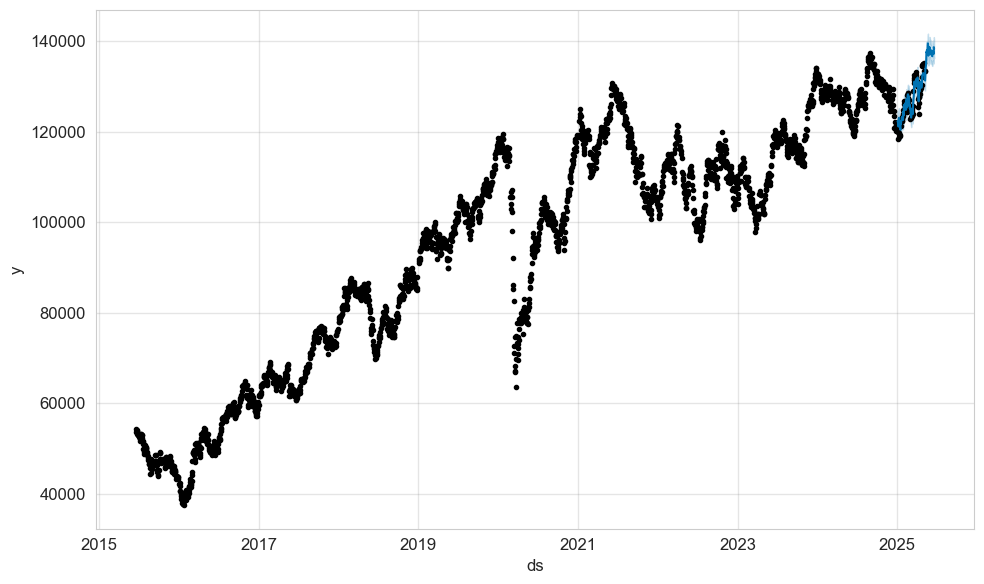

In [138]:
# previsão em azul
fig1 = m.plot(forecast)

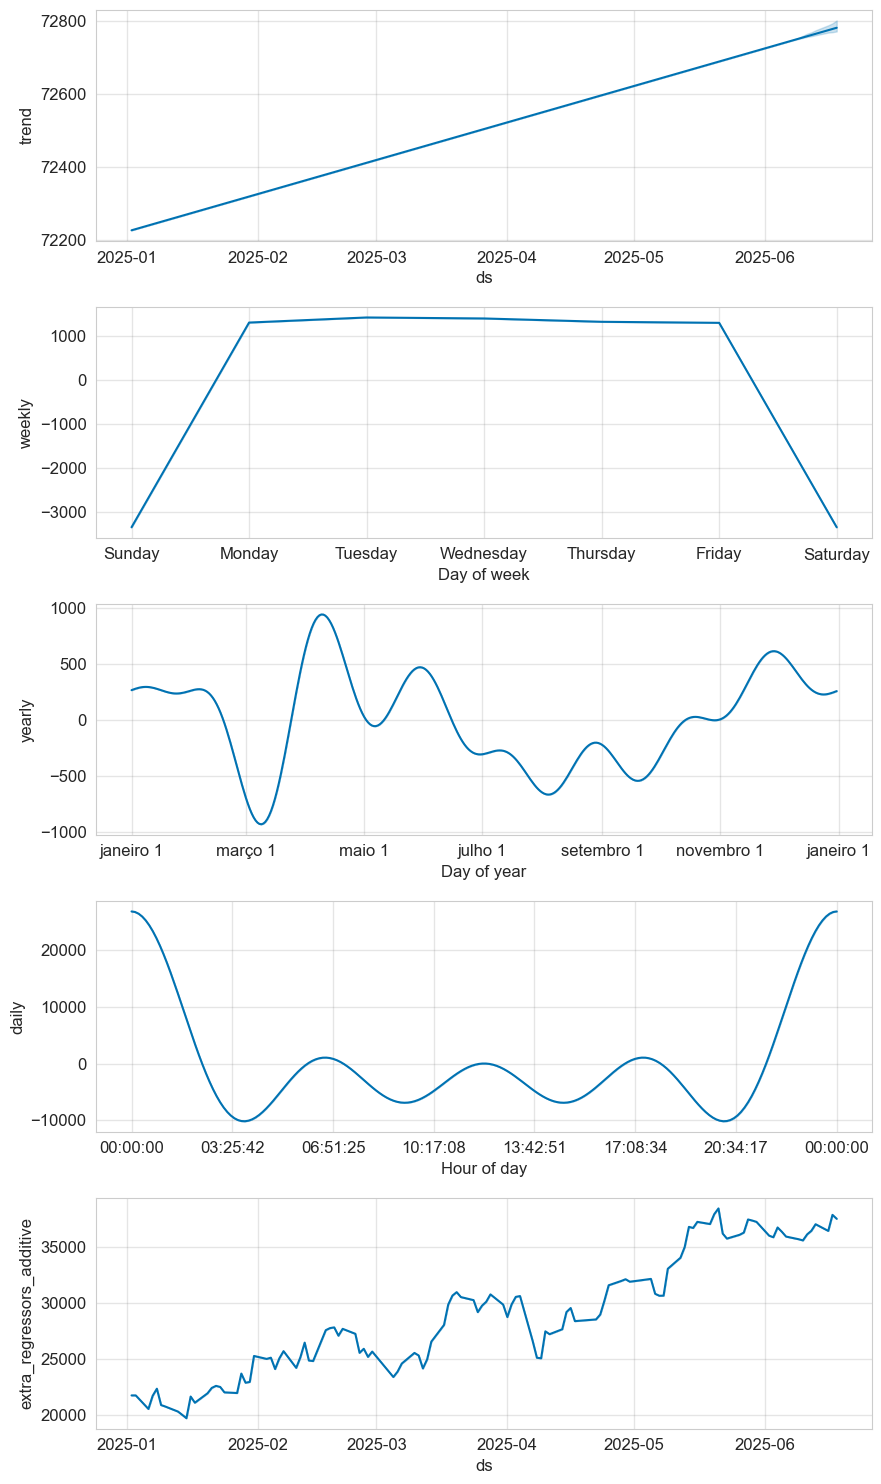

In [139]:
fig2 = m.plot_components(forecast)


In [140]:
# juntando dados reais com o teste para comparar
pred = forecast.iloc[-30:]
df_results = pd.merge(test_prophet[['ds', 'y']], pred[['ds', 'yhat']], on='ds')
df_results['residue'] = df_results['y'] - df_results['yhat']
df_results

,ds,y,yhat,residue
0,2025-05-08,136232,131346.154242,4885.845758
1,2025-05-09,136512,133722.624734,2789.375266
2,2025-05-12,136563,134776.456775,1786.543225
3,2025-05-13,138963,135873.918072,3089.081928
4,2025-05-14,138423,137674.854876,748.145124
5,2025-05-15,139334,137535.862465,1798.137535
6,2025-05-16,139187,138090.814135,1096.185865
7,2025-05-19,139636,138017.991275,1618.008725
8,2025-05-20,140110,139049.117797,1060.882203
9,2025-05-21,137881,139572.467233,-1691.467233


In [141]:
# R-quadrado (R²)
r2 = r2_score(df_results['y'], df_results['yhat'])
print(f"R² (R-Score): {r2:.4f}")

# Erro Quadrático Médio (MSE)
mse = mean_squared_error(df_results['y'], df_results['yhat'])
print(f"Mean Squared Error (MSE): {mse:,.2f}")

# Erro Absoluto Médio (MAE)
mae = mean_absolute_error(df_results['y'], df_results['yhat'])
print(f"Mean Absolute Error (MAE): {mae:,.2f}")

R² (R-Score): -0.6643
Mean Squared Error (MSE): 2,455,843.84
Mean Absolute Error (MAE): 1,171.08


In [142]:
last_day_close = df_prophet['y'].shift(1).iloc[-30:]

# Determina a direção real e a prevista em relação ao fechamento anterior REAL
real_direction = (df_results['y'].values > last_day_close.values)
pred_direction = (df_results['yhat'].values > last_day_close.values)

directional_accuracy = np.mean(real_direction == pred_direction) * 100
print(f"Acurácia direcional: {directional_accuracy:.2f}%")

Acurácia direcional: 46.67%


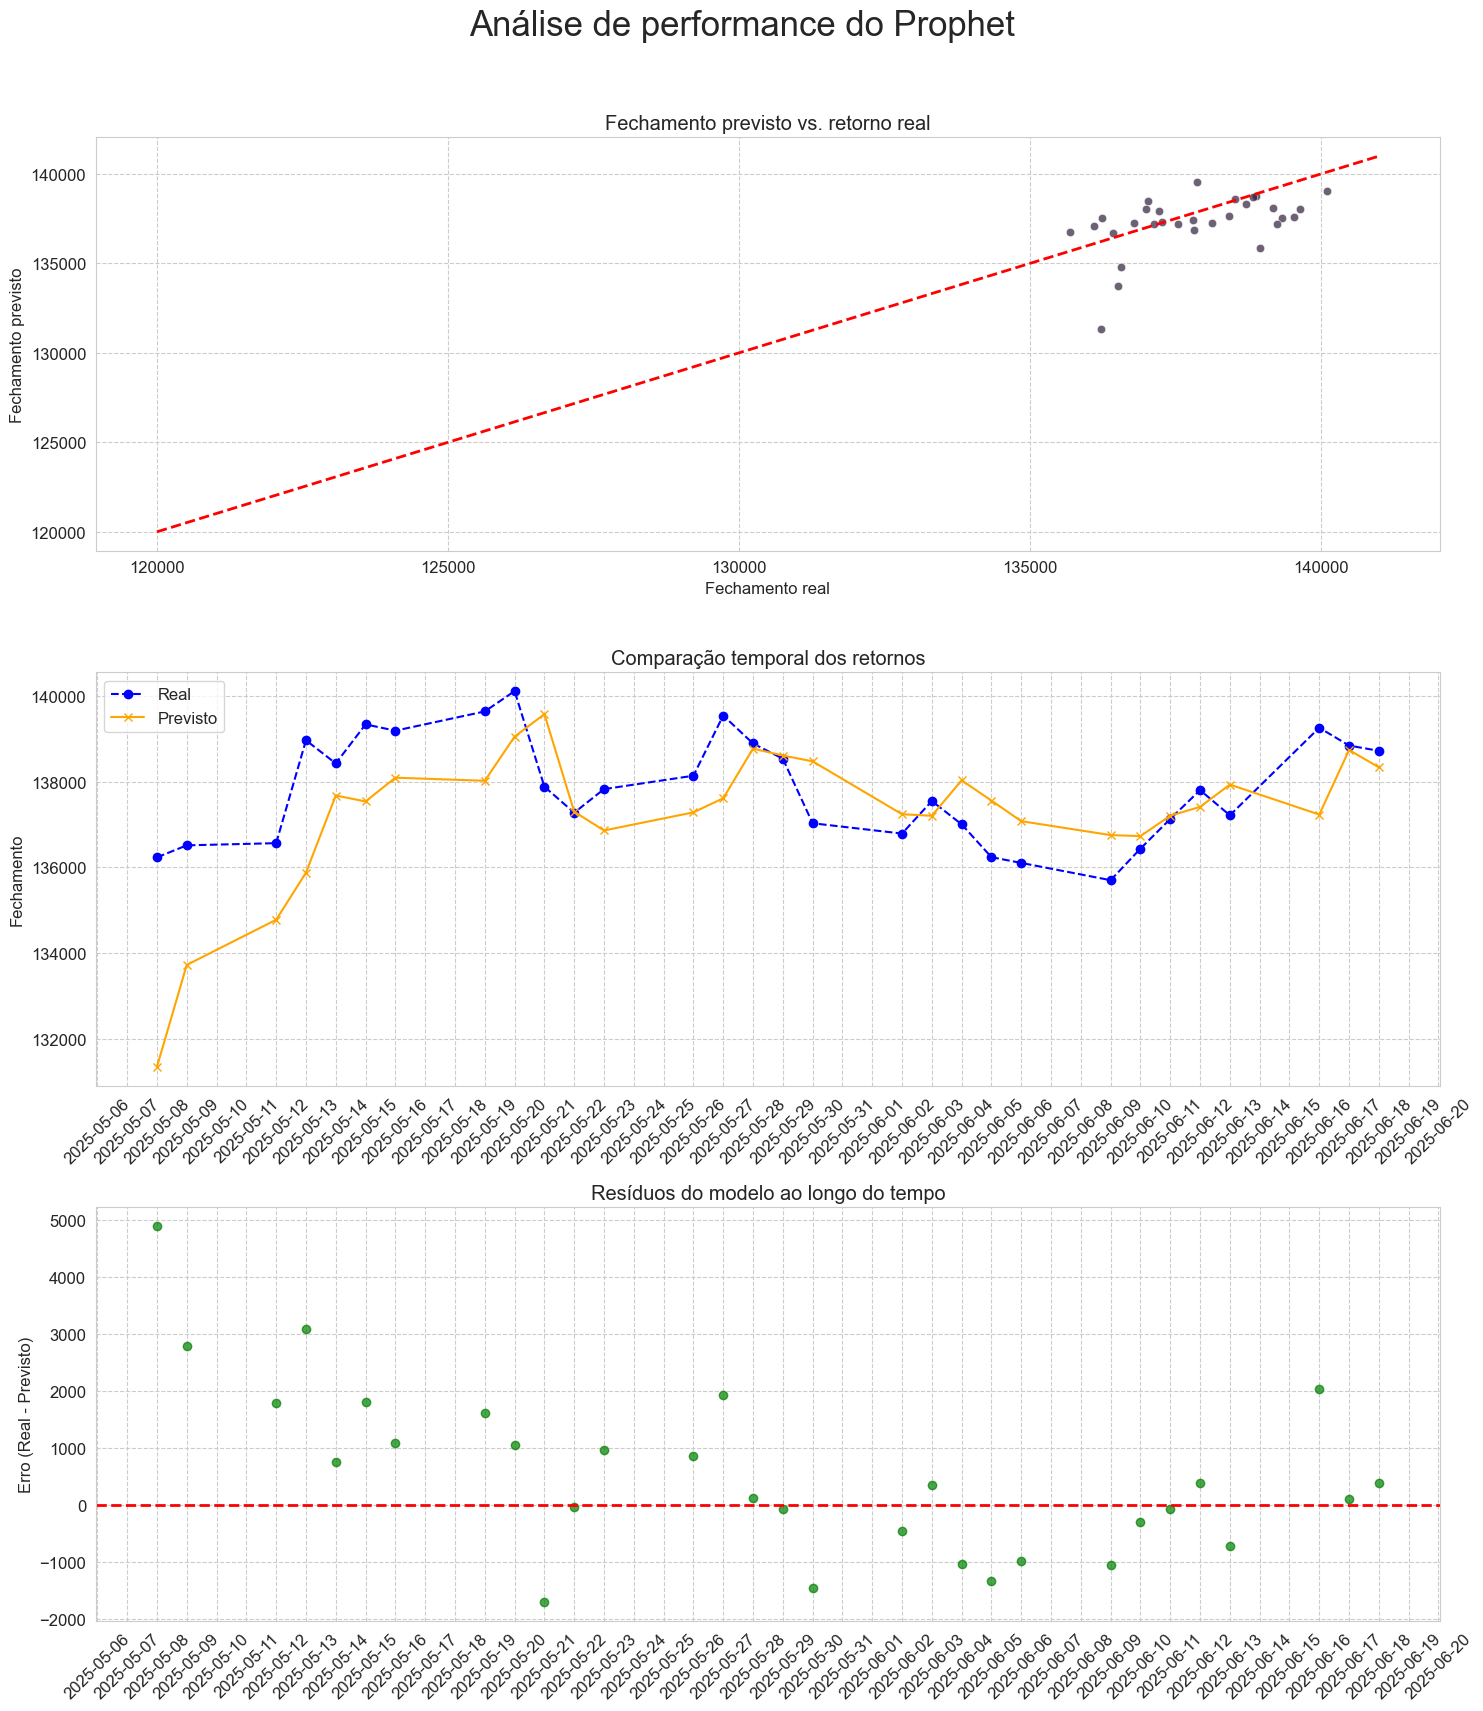

In [143]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18))
fig.suptitle(f'Análise de performance do Prophet')

# scatter Plot de previsto vs. real
sns.scatterplot(ax=axes[0], x='y', y='yhat', data=df_results, alpha=0.7)
axes[0].plot([120000, 141000], [120000, 141000], color='red', linestyle='--', lw=2)
axes[0].set_title('Fechamento previsto vs. retorno real')
axes[0].set_xlabel('Fechamento real')
axes[0].set_ylabel('Fechamento previsto')

# série temporal (linhas do previsto e real ao longo do tempo)
axes[1].plot(df_results['ds'], df_results['y'], label='Real', color='blue', marker='o', linestyle='--')
axes[1].plot(df_results['ds'], df_results['yhat'], label='Previsto', color='orange', marker='x', linestyle='-')
axes[1].set_title('Comparação temporal dos retornos')
axes[1].set_xlabel('')
axes[1].set_ylabel('Fechamento')
axes[1].legend()

# Configura o eixo x com ticks diários
axes[1].xaxis.set_major_locator(mdates.DayLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# análise de resíduos
axes[2].scatter(df_results['ds'], df_results['residue'], alpha=0.7, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', lw=2)
axes[2].set_title('Resíduos do modelo ao longo do tempo')
axes[2].set_xlabel('')
axes[2].set_ylabel('Erro (Real - Previsto)')

axes[2].xaxis.set_major_locator(mdates.DayLocator())
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()